In [ ]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy = True

# pyEPR Startup Example
##### Single transmon qubit mode analysis  
Author: Zlatko Minev

## <div style="background:#BBFABB;line-height:2em;">Load pyEPR<div>

In [29]:
import pyEPR as epr
import pandas as pd

This loads the `pyEPR` package under the shorthand name `epr`.

We can access the main different submodules, like this:
  * `epr.calcs`  : calculations tools 
  * `epr.ansys`  : tools for controlling ansys hfss, q3d, etc.
  * `epr.toolbox`: useful and handly toolbox for plotting, pythonic manipulations, etc. 
  * `epr.core`  : The core module of analysis functions. This does not need ot be accessed by the user typically. It essentually provides the main two classes: ProjectInfo, DistributedAnalysis, and QuantumAnalysis -- which represent the different stages of the simulation. Let us examine these next. 
  
EPR also has some handy functions, which we will explore:

In [3]:
print('Parsing unis:  1um =', 
      epr.parse_entry('1um', 'meters'), 'meters')

print(f"""For   L_J = 11 nH, the Josephson junction energy is
      E_J = {epr.calcs.Convert.Ej_from_Lj(11, 'nH', 'GHz'):.1f} GHz""")

Parsing unis:  1um = 1e-06 meters
For   L_J = 11 nH, the Josephson junction energy is
      E_J = 14.9 GHz


#### Load Ansys HFSS tutorial file  

Let us first determine where the example file is stored.
For tutorial, let us get the path to the tutorial folder.

In [4]:
# Load Path temporarily just to find where the tutorial folder is
# return path_to_project
# from pathlib import Path
# path_to_project = Path(epr.__file__).parent.parent / '_example_files'
# print(f'We will the example project located in\n {path_to_project}')

path_to_project='C:\\_Lib\\pyEPR\\_example_files'

## <div style="background:#BBFABB;line-height:2em;">Connect to Ansys HFSS<div>

Now, we will open Ansys Desktop and connect to a specific project.

You can use the following creation keyword arguments to specify which design to look at 

 * `project_path`: 
    Directory path to the hfss project file. Should be the directory, not the file.
    default = None: Assumes the project is open, and thus gets the project based on `project_name`
 * `project_name`:
    Name of the project within the project_path. "None" will get the current active one.
 * `design_name` :
    Name of the design within the project. "None" will get the current active one.
 * `setup_name`  :
    Name of the setup within the design. "None" will get the current active one.

Use `?epr.ProjectInfo` to see all the arguments

In [19]:
pinfo = epr.ProjectInfo(project_path = path_to_project, 
                         project_name = 'pyEPR_tutorial1',
                         design_name  = '1. single_transmon')

INFO 01:28PM [connect]: Connecting to Ansys Desktop API...
INFO 01:28PM [load_ansys_project]: 	File path to HFSS project found.
INFO 01:28PM [load_ansys_project]: 	Opened Ansys App
INFO 01:28PM [load_ansys_project]: 	Opened Ansys Desktop v2018.0.0
INFO 01:28PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/_Lib/pyEPR/_example_files/
	Project:   pyEPR_tutorial1
INFO 01:28PM [connect]: 	Opened active design
	Design:    1. single_transmon [Solution type: Eigenmode]
INFO 01:28PM [get_setup]: 	Opened setup `Setup1`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 01:28PM [connect]: 	Connection to Ansys established successfully. 😀 



Let's see what the design type was using the `design` object

In [5]:
pinfo.design.solution_type

'Eigenmode'

Let us see what all the object in the design are. `pinfo` contains a function to retrieve these for convenience.

In [6]:
pinfo.get_all_object_names()

['cavity_enclosure',
 'substrate',
 'rect_jj1',
 'pad_lower',
 'pad_upper',
 'line_jj1']

Let's see what variables there are in the design. 

In [7]:
pinfo.get_all_variables_names()

['width',
 'height',
 'length',
 'c_w',
 'c_h',
 'c_l',
 'pad_gap',
 'jj_w',
 'pad_w',
 'pad_h',
 'Lj_1']

We can also get the names of the setups

In [8]:
pinfo.design.get_setup_names()

('Setup1',)

We can also get information such as mesh statistic and convergence (if you have already solved the model)

In [9]:
pinfo.setup.get_mesh_stats()

,Unnamed: 0,Num Tets,Min edge length,Max edge length,RMS edge length,Min tet vol,Max tet vol,Mean tet vol,Std Devn (vol)
0,cavity_enclosure,11883,0.002961,3.53530,1.690790,1.035610e-09,2.468820,0.322094,0.422247
1,substrate,4279,0.003447,1.60124,0.297105,3.210630e-09,0.059445,0.001898,0.006169


We can also see how many modes we solved for

In [10]:
pinfo.setup.n_modes

'2'

##  <div style="background:#BBFABB;line-height:2em;"> Josephson tunnel junctions (non-linear elemetns) </div>

To analysze the quantum part of the model, let us specify the junctions in the model. 

The junciton is defined as described in the paper and on the landing page of pyEPR. There is a rectangle sheet inductance and a polyline that defines the current and voltage on the sheet.  

Let us call the single junction `j1`. A junction has the following properties:

  1. **Lj_variable** : Name of HFSS variable that specifies junction inductance Lj defined on the boundary condition in HFSS
  2. **rect**        : Name of HFSS rectangle on which lumped boundary condition is specified.
  3. **line**        : Name of HFSS polyline which spans the length of the recntalge. Used to define the voltage across the junction. 
  4. **Cj_variable** : (Optional) Name of HFSS variable that specifies junction lumped capacitance Cj defined on the boundary condition in HFSS. This is optional.

In [20]:
pinfo.junctions['j1'] = {'Lj_variable' : 'Lj_1', 
                         'rect'        : 'rect_jj1', 
                         'line'        : 'line_jj1', 
                         'length'      : epr.parse_units('100um')}


# Check that valid names of variables and objects have been supplied.
# An error is raised with a message if something is wrong.
pinfo.validate_junction_info()  

## <div style="background:#BBFABB;line-height:2em;">Micrwoave Analysis: <br>Run analysis on an eigenmode solution  <div>

Assumeing we have field solutions saved for the HFSS *eigenmode* design, we can now create the analysis object from the 
calss `DistributedAnalysis`.

**Run analysis:** (Tutorial action) Run the analysis in the design model. 
This can be done manually, or using pyEPR.

In [12]:
# Calling this function will run an analysis of the design in the background. 
# The console will wait for HFSS to complete.
pinfo.setup.analyze()

INFO 01:32PM [analyze]: Analyzing setup Setup1


**Run optimetrics**

The following will get the frequencies and Qs from HFSS. 

In [13]:
# Calling this function will run an analysis on all the optimetrics  the design in the background. 
# The console will wait for HFSS to complete.
# This requires optimetrics license by HFSS. 
pinfo.design.optimetrics.solve_setup(pinfo.design.optimetrics.get_setup_names()[0])

**EPR Analysis object**

Let us introduce the core analysis object of `pyEPR`, which will be a class instance of `epr.DistributedAnalysis`. This is how we will run most of our analysis.

Let us recover the eigenmode frequencies of the first variation we ran, which is indexed by '0'.

In [6]:
# This is the core object for interacting with HFSS
# and running analysis within HFSS.
eprh = epr.DistributedAnalysis(pinfo) # epr hfss analysis 

Design "1. single_transmon" info:
	# eigenmodes    2
	# variations    11


In [15]:
eprh.get_ansys_variables()

variation,0,1,2,3,4,5,6,7,8,9,10
c_h,0.4mm,0.4mm,0.4mm,0.4mm,0.4mm,0.4mm,0.4mm,0.4mm,0.4mm,0.4mm,0.4mm
c_l,7mm,7mm,7mm,7mm,7mm,7mm,7mm,7mm,7mm,7mm,7mm
c_w,2.9mm,2.9mm,2.9mm,2.9mm,2.9mm,2.9mm,2.9mm,2.9mm,2.9mm,2.9mm,2.9mm
height,17mm,17mm,17mm,17mm,17mm,17mm,17mm,17mm,17mm,17mm,17mm
jj_w,50um,50um,50um,50um,50um,50um,50um,50um,50um,50um,50um
length,33mm,33mm,33mm,33mm,33mm,33mm,33mm,33mm,33mm,33mm,33mm
Lj_1,12nH,7nH,8nH,9nH,10nH,11nH,6nH,7.2nH,8.4nH,9.6nH,10.8nH
pad_gap,100um,100um,100um,100um,100um,100um,100um,100um,100um,100um,100um
pad_h,350um,350um,350um,350um,350um,350um,350um,350um,350um,350um,350um
pad_w,0.75mm,0.75mm,0.75mm,0.75mm,0.75mm,0.75mm,0.75mm,0.75mm,0.75mm,0.75mm,0.75mm


In [ ]:
eprh.get_ansys_frequencies_all()

In [ ]:
eprh.hfss_report_full_convergence();

In [ ]:
We can see that the convergence wasn't actually terrific, though we only used 60,000 tets. However, there seems to be a divergence above 15 passes in this example. We will probably need to change our mesh operations to create a monotonic convergence.

However, for the purpose of the tutorial, let us press forward. 

You can use these autogenerated reports to keep track of your simulations.
This is still all at the clasical level. Take a look at the other methods, including
 * `hfss_report_full_convergence`
 * `hfss_report_f_convergence`
 * `get_convergence`
 * `get_mesh_statistics`
 * `get_freqs_bare_pd`
 * ...
 
For example, you can get tables of the freqs and Qs using 
```python
Fs, Qs = eprh.get_freqs_bare_pd(variation='0')
```

In [9]:
import pandas as pd
for variation in eprh.variations[:2]: # just for the first 2
    Fs, Qs = eprh.get_freqs_bare_pd(variation=variation, frame=False)
    display(pd.DataFrame({'Freq. (GHz)':Fs, 'Quality Factor':Qs}))

,Freq. (GHz),Quality Factor
0,4.654203,inf
1,9.249395,inf


,Freq. (GHz),Quality Factor
0,5.461932,inf
1,9.250908,inf


The Q is infinite, since we have not included dissipation yet in this example. The row index is the mode number

####  Full analysis

Let's now jump ahead to the full analysis.

In [21]:
# Do EPR analysis for all modes and all variations 
# If you want to only analze a certain variation, you can change the 
# default keyword argeumetns variations=None, modes=None
eprh.do_EPR_analysis();


Variation 0  [1/11]

  Mode 0 at 4.65 GHz   [1/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               97.9%      1.959   0.04085

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 97.99%
	j1              0.977627  (+)        0.0200648
		(U_tot_cap-U_tot_ind)/mean=1.07%

  Mode 1 at 9.25 GHz   [2/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.4%      1.002    0.9981

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_1j   sign s_1j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 92.50%
	j1              0.00335009  (+)        0.000271552
		(U_tot_cap-U_tot_ind)/mean=0.03%

Variation 1  [2/11]

  Mode 0 at 5.46 GHz   [1/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E

    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               97.6%      1.953   0.04742

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.38%
	j1              0.973997  (+)        0.0160034
		(U_tot_cap-U_tot_ind)/mean=0.88%

  Mode 1 at 9.24 GHz   [2/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.5%      1.002    0.9975

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_1j   sign s_1j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 93.92%
	j1              0.00417137  (+)        0.000270008
		(U_tot_cap-U_tot_ind)/mean=0.03%

Variation 10  [11/11]

  Mode 0 at 4.38 GHz   [1/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               97.9%      1.

##### Getting more info

In general, to see more info when running commands , set the logger level

In [ ]:
import logging
epr.logger.setLevel(logging.DEBUG)

## <div style="background:#BBFABB;line-height:2em;"> Quantum Hamiltonian Analysis:<br> Load mw-analysis results and perform hamiltonian analysis on the solutions  <div>

We will now postprocess the mw analysis to obtain the quantum Hamiltonian. 

The code object of postprocessing is `epra`, an instance of `epr.QuantumAnalysis`.

	 Differences in variations:


variation,0,1,2,3,4,5,6,7,8,9,10
_Lj_1,12nH,7nH,8nH,9nH,10nH,11nH,6nH,7.2nH,8.4nH,9.6nH,10.8nH





 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.021852
1    1.076986
dtype: float64

Pm_norm idx =
      j1
0   True
1  False

*** Different parameters


_Lj_1    12nH
Name: 0, dtype: object



*** P (participation matrix, not normlz.)
         j1
0  0.958397
1  0.003349

*** S (sign-bit matrix)
   s_j1
0     1
1     1
*** P (participation matrix, normalized.)
      0.98
    0.0033

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       191     2.59
      2.59  0.00881

*** Chi matrix ND (MHz) 
       213     2.59
      2.59  0.00791

*** Frequencies O1 PT (MHz)
0    4462.258548
1    9248.090375
dtype: float64

*** Frequencies ND (MHz)
0    4453.432140
1    9248.072666
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 1

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.018126
1    1.058116
dtype: float64

Pm_norm idx =
      j1
0   True
1  False

*** Different parameters


_Lj_1    7nH
Name: 1, dtype: object



*** P (participation matrix, not normlz.)
         j1
0  0.946982
1  0.007610

*** S (sign-bit matrix)
   s_j1
0     1
1     1
*** P (participation matrix, normalized.)
      0.96
    0.0076

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       148     3.97
      3.97   0.0265

*** Chi matrix ND (MHz) 
       159     3.76
      3.76   0.0234

*** Frequencies O1 PT (MHz)
0    5311.500940
1    9248.896765
dtype: float64

*** Frequencies ND (MHz)
0    5307.056048
1    9248.916555
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 2

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.018107
1    1.053623
dtype: float64

Pm_norm idx =
      j1
0   True
1  False

*** Different parameters


_Lj_1    8nH
Name: 2, dtype: object



*** P (participation matrix, not normlz.)
         j1
0  0.952112
1  0.005940

*** S (sign-bit matrix)
   s_j1
0     1
1     1
*** P (participation matrix, normalized.)
      0.97
    0.0059

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       151     3.34
      3.34   0.0185

*** Chi matrix ND (MHz) 
       163     3.21
      3.21   0.0167

*** Frequencies O1 PT (MHz)
0    4970.402103
1    9245.131630
dtype: float64

*** Frequencies ND (MHz)
0    4965.512637
1    9245.136930
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 3

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.018108
1    1.077830
dtype: float64

Pm_norm idx =
      j1
0   True
1  False

*** Different parameters


_Lj_1    9nH
Name: 3, dtype: object



*** P (participation matrix, not normlz.)
         j1
0  0.955989
1  0.004828

*** S (sign-bit matrix)
   s_j1
0     1
1     1
*** P (participation matrix, normalized.)
      0.97
    0.0048

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       152     2.89
      2.89   0.0137

*** Chi matrix ND (MHz) 
       165     2.83
      2.83   0.0123

*** Frequencies O1 PT (MHz)
0    4681.654935
1    9242.361149
dtype: float64

*** Frequencies ND (MHz)
0    4676.355758
1    9242.355938
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 4

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.018110
1    1.094943
dtype: float64

Pm_norm idx =
      j1
0   True
1  False

*** Different parameters


_Lj_1    10nH
Name: 4, dtype: object



*** P (participation matrix, not normlz.)
         j1
0  0.958910
1  0.004066

*** S (sign-bit matrix)
   s_j1
0     1
1     1
*** P (participation matrix, normalized.)
      0.98
    0.0041

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       154     2.58
      2.58   0.0108

*** Chi matrix ND (MHz) 
       168     2.56
      2.56  0.00989

*** Frequencies O1 PT (MHz)
0    4438.909571
1    9240.377080
dtype: float64

*** Frequencies ND (MHz)
0    4433.211497
1    9240.363227
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 5

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.018105
1    1.100850
dtype: float64

Pm_norm idx =
      j1
0   True
1  False

*** Different parameters


_Lj_1    11nH
Name: 5, dtype: object



*** P (participation matrix, not normlz.)
         j1
0  0.961252
1  0.003502

*** S (sign-bit matrix)
   s_j1
0     1
1     1
*** P (participation matrix, normalized.)
      0.98
    0.0035

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       155     2.34
      2.34  0.00881

*** Chi matrix ND (MHz) 
       170     2.37
      2.37  0.00819

*** Frequencies O1 PT (MHz)
0    4228.271441
1    9238.811072
dtype: float64

*** Frequencies ND (MHz)
0    4222.195616
1    9238.788955
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 6

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.018048
1    1.038894
dtype: float64

Pm_norm idx =
      j1
0   True
1  False

*** Different parameters


_Lj_1    6nH
Name: 6, dtype: object



*** P (participation matrix, not normlz.)
         j1
0  0.938048
1  0.011074

*** S (sign-bit matrix)
   s_j1
0     1
1     1
*** P (participation matrix, normalized.)
      0.95
     0.011

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       147     5.33
      5.33   0.0482

*** Chi matrix ND (MHz) 
       157     4.95
      4.95   0.0413

*** Frequencies O1 PT (MHz)
0    5784.214183
1    9256.163334
dtype: float64

*** Frequencies ND (MHz)
0    5780.133360
1    9256.213881
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 7

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.017961
1    1.057319
dtype: float64

Pm_norm idx =
      j1
0   True
1  False

*** Different parameters


_Lj_1    7.2nH
Name: 7, dtype: object



*** P (participation matrix, not normlz.)
         j1
0  0.949155
1  0.006943

*** S (sign-bit matrix)
   s_j1
0     1
1     1
*** P (participation matrix, normalized.)
      0.97
    0.0069

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       147     3.66
      3.66   0.0227

*** Chi matrix ND (MHz) 
       158     3.49
      3.49   0.0202

*** Frequencies O1 PT (MHz)
0    5204.173567
1    9246.745591
dtype: float64

*** Frequencies ND (MHz)
0    5199.717893
1    9246.759898
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 8

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.021443
1    1.049437
dtype: float64

Pm_norm idx =
      j1
0   True
1  False

*** Different parameters


_Lj_1    8.4nH
Name: 8, dtype: object



*** P (participation matrix, not normlz.)
         j1
0  0.948643
1  0.006260

*** S (sign-bit matrix)
   s_j1
0     1
1     1
*** P (participation matrix, normalized.)
      0.97
    0.0063

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       181     3.95
      3.95   0.0216

*** Chi matrix ND (MHz) 
       198     3.71
      3.71   0.0185

*** Frequencies O1 PT (MHz)
0    5299.328226
1    9253.534359
dtype: float64

*** Frequencies ND (MHz)
0    5292.642011
1    9253.557401
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 9

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.017983
1    1.074871
dtype: float64

Pm_norm idx =
      j1
0   True
1  False

*** Different parameters


_Lj_1    9.6nH
Name: 9, dtype: object



*** P (participation matrix, not normlz.)
         j1
0  0.958655
1  0.004170

*** S (sign-bit matrix)
   s_j1
0     1
1     1
*** P (participation matrix, normalized.)
      0.98
    0.0042

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       152     2.57
      2.57   0.0109

*** Chi matrix ND (MHz) 
       165     2.54
      2.54  0.00995

*** Frequencies O1 PT (MHz)
0    4502.994023
1    9239.691010
dtype: float64

*** Frequencies ND (MHz)
0    4497.549901
1    9239.680046
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 10

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.017630
1    1.097977
dtype: float64

Pm_norm idx =
      j1
0   True
1  False

*** Different parameters


_Lj_1    10.8nH
Name: 10, dtype: object



*** P (participation matrix, not normlz.)
         j1
0  0.961945
1  0.003451

*** S (sign-bit matrix)
   s_j1
0     1
1     1
*** P (participation matrix, normalized.)
      0.98
    0.0035

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       152     2.26
      2.26  0.00839

*** Chi matrix ND (MHz) 
       166     2.29
      2.29  0.00781

*** Frequencies O1 PT (MHz)
0    4230.917828
1    9237.508770
dtype: float64

*** Frequencies ND (MHz)
0    4225.067684
1    9237.488016
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]


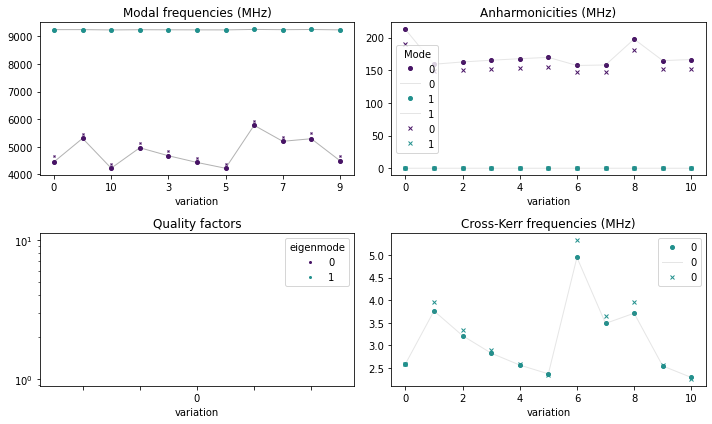

In [22]:
%matplotlib inline
# plot the figures in the notebook. 

# This is the core object for working with post processing data from HFSS
# This iwll load the saved solutions from above
epra = epr.QuantumAnalysis(eprh.data_filename)

# Analyze 
epra.analyze_all_variations(cos_trunc = 8, fock_trunc = 15)
epra.plot_hamiltonian_results();

## <div style="background:#BBFABB;line-height:2em;"> Swept variable analysis driven thorugh pyEPR:<br> Sweep variable in hfss, analyze microwaves, then analyze quantum<div>

Let us now run a more complicated example, where we will sweep $L_j$. This demonstrates some of the `pyEPR` funcationality. 

**Classical microwave, distributed analysis**

Sweep variable in HFSS, run circuits

In [ ]:
import numpy as np 

### Configure setup
### Set the maximum number of passes on the analysis and a few other
pinfo.setup.passes = 15
pinfo.setup.min_freq = '3.2GHz'
pinfo.setup.modes = 2 
pinfo.setup.delta_f = 0.02 
pinfo.setup.basis_order = epr.ansys.BASIS_ORDER['Mixed Order']


### What to sweep 
# Define sweep variables to go over
swp_var = 'Lj_1' # name
# how to convert sweep param to string variable in nanoHeries. 
to_swp_val = lambda x: f'{x}nH' 

### Run Sweep 
for swp_param in np.linspace(6, 12, 6):
    swp_val = to_swp_val(swp_param)
    epr.logger.info(f'Setting sweep variable {swp_var}={swp_val}')
    pinfo.design.set_variable(swp_var, swp_val)
    pinfo.setup.analyze()

**EPR mw analysis**

Classical-to-quantum bridge. 

INFO 01:19PM [hfss_report_full_convergence]: Creating report for variation 0


Design "1. single_transmon" info:
	# eigenmodes    2
	# variations    11


INFO 01:19PM [hfss_report_f_convergence]: Saved convergences to D:\data-pyEPR\pyEPR_tutorial1\1. single_transmon\hfss_eig_f_convergence.csv


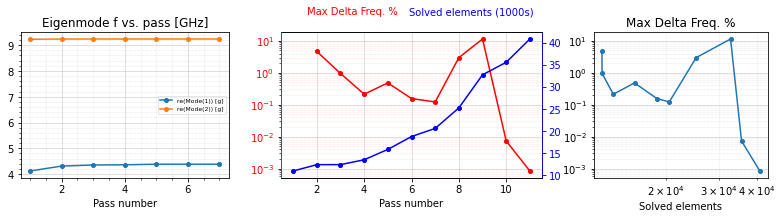

INFO 01:19PM [hfss_report_full_convergence]: Creating report for variation 1
INFO 01:19PM [hfss_report_f_convergence]: Saved convergences to D:\data-pyEPR\pyEPR_tutorial1\1. single_transmon\hfss_eig_f_convergence.csv


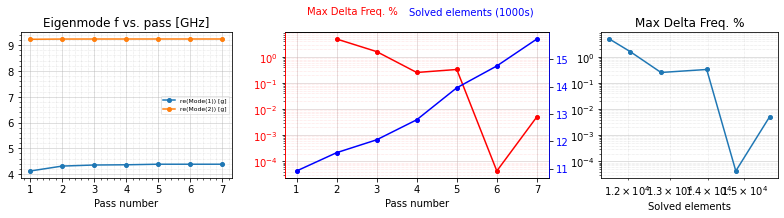

INFO 01:19PM [hfss_report_full_convergence]: Creating report for variation 2
INFO 01:19PM [hfss_report_f_convergence]: Saved convergences to D:\data-pyEPR\pyEPR_tutorial1\1. single_transmon\hfss_eig_f_convergence.csv


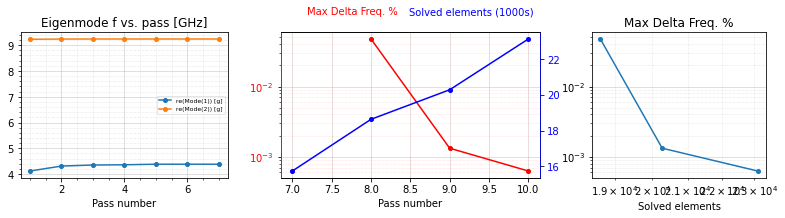

INFO 01:19PM [hfss_report_full_convergence]: Creating report for variation 3
INFO 01:19PM [hfss_report_f_convergence]: Saved convergences to D:\data-pyEPR\pyEPR_tutorial1\1. single_transmon\hfss_eig_f_convergence.csv


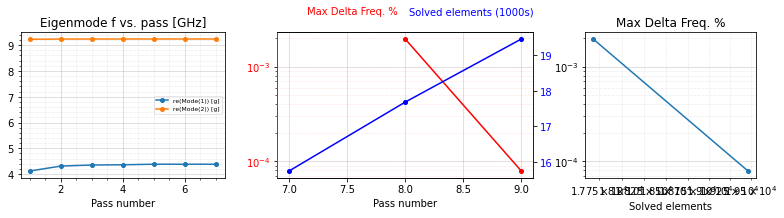

INFO 01:19PM [hfss_report_full_convergence]: Creating report for variation 4
INFO 01:19PM [hfss_report_f_convergence]: Saved convergences to D:\data-pyEPR\pyEPR_tutorial1\1. single_transmon\hfss_eig_f_convergence.csv


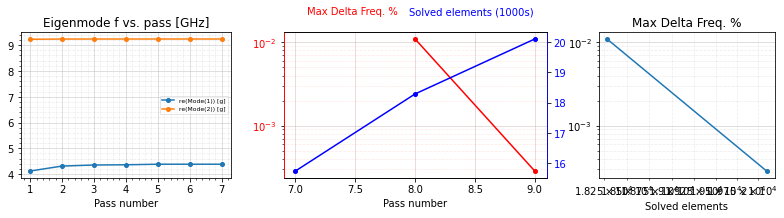

INFO 01:20PM [hfss_report_full_convergence]: Creating report for variation 5
INFO 01:20PM [hfss_report_f_convergence]: Saved convergences to D:\data-pyEPR\pyEPR_tutorial1\1. single_transmon\hfss_eig_f_convergence.csv


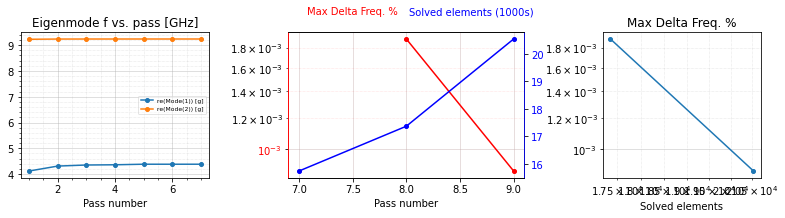

INFO 01:20PM [hfss_report_full_convergence]: Creating report for variation 6
INFO 01:20PM [hfss_report_f_convergence]: Saved convergences to D:\data-pyEPR\pyEPR_tutorial1\1. single_transmon\hfss_eig_f_convergence.csv


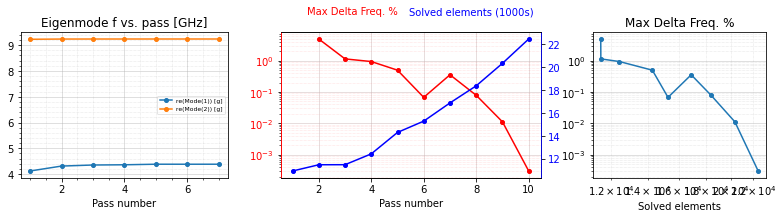

INFO 01:20PM [hfss_report_full_convergence]: Creating report for variation 7
INFO 01:20PM [hfss_report_f_convergence]: Saved convergences to D:\data-pyEPR\pyEPR_tutorial1\1. single_transmon\hfss_eig_f_convergence.csv


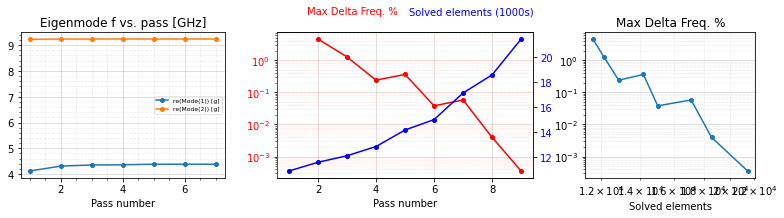

INFO 01:20PM [hfss_report_full_convergence]: Creating report for variation 8
INFO 01:20PM [hfss_report_f_convergence]: Saved convergences to D:\data-pyEPR\pyEPR_tutorial1\1. single_transmon\hfss_eig_f_convergence.csv


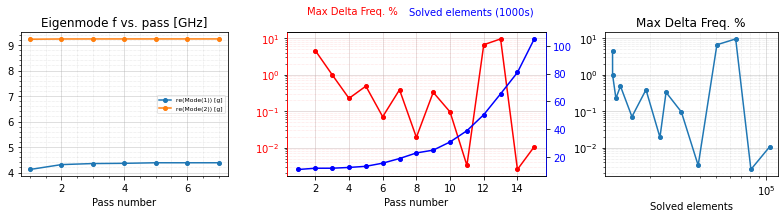

INFO 01:20PM [hfss_report_full_convergence]: Creating report for variation 9
INFO 01:20PM [hfss_report_f_convergence]: Saved convergences to D:\data-pyEPR\pyEPR_tutorial1\1. single_transmon\hfss_eig_f_convergence.csv


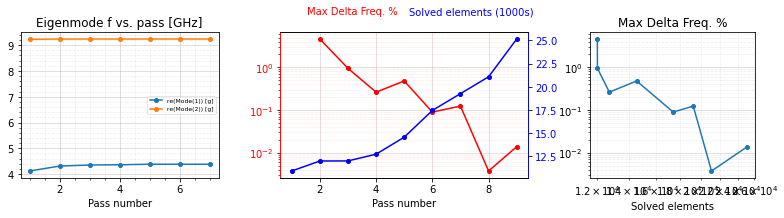

INFO 01:20PM [hfss_report_full_convergence]: Creating report for variation 10
INFO 01:20PM [hfss_report_f_convergence]: Saved convergences to D:\data-pyEPR\pyEPR_tutorial1\1. single_transmon\hfss_eig_f_convergence.csv


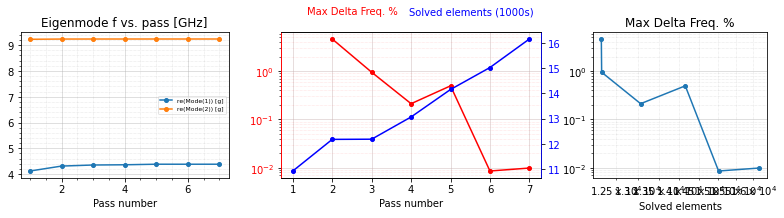

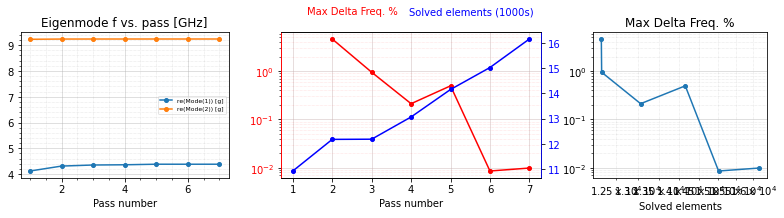

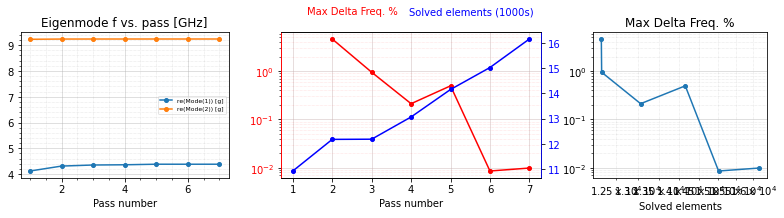

In [7]:
eprh = epr.DistributedAnalysis(pinfo) # epr hfss analysis 
eprh.hfss_report_full_convergence()

In [ ]:
# Do EPR analysis for all modes and all variations 
eprh.do_EPR_analysis();

**Quantum analysis** 

Perform the analysis and plot the results.

In [23]:
# This is the core object for working with post processing data from HFSS
# This will load the saved solutions from above
epra = epr.QuantumAnalysis(eprh.data_filename)

	 Differences in variations:


variation,0,1,2,3,4,5,6,7,8,9,10
_Lj_1,12nH,7nH,8nH,9nH,10nH,11nH,6nH,7.2nH,8.4nH,9.6nH,10.8nH


attrdict.dictionary.AttrDict

In [26]:
# Analyze 
epra.analyze_all_variations(cos_trunc = 8, fock_trunc = 15);


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.021852
1    1.076986
dtype: float64

Pm_norm idx =
      j1
0   True
1  False

*** Different parameters


_Lj_1    12nH
Name: 0, dtype: object



*** P (participation matrix, not normlz.)
         j1
0  0.958397
1  0.003349

*** S (sign-bit matrix)
   s_j1
0     1
1     1
*** P (participation matrix, normalized.)
      0.98
    0.0033

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       191     2.59
      2.59  0.00881

*** Chi matrix ND (MHz) 
       213     2.59
      2.59  0.00791

*** Frequencies O1 PT (MHz)
0    4462.258548
1    9248.090375
dtype: float64

*** Frequencies ND (MHz)
0    4453.432140
1    9248.072666
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 1

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.018126
1    1.058116
dtype: float64

Pm_norm idx =
      j1
0   True
1  False

*** Different parameters


_Lj_1    7nH
Name: 1, dtype: object



*** P (participation matrix, not normlz.)
         j1
0  0.946982
1  0.007610

*** S (sign-bit matrix)
   s_j1
0     1
1     1
*** P (participation matrix, normalized.)
      0.96
    0.0076

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       148     3.97
      3.97   0.0265

*** Chi matrix ND (MHz) 
       159     3.76
      3.76   0.0234

*** Frequencies O1 PT (MHz)
0    5311.500940
1    9248.896765
dtype: float64

*** Frequencies ND (MHz)
0    5307.056048
1    9248.916555
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 2

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.018107
1    1.053623
dtype: float64

Pm_norm idx =
      j1
0   True
1  False

*** Different parameters


_Lj_1    8nH
Name: 2, dtype: object



*** P (participation matrix, not normlz.)
         j1
0  0.952112
1  0.005940

*** S (sign-bit matrix)
   s_j1
0     1
1     1
*** P (participation matrix, normalized.)
      0.97
    0.0059

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       151     3.34
      3.34   0.0185

*** Chi matrix ND (MHz) 
       163     3.21
      3.21   0.0167

*** Frequencies O1 PT (MHz)
0    4970.402103
1    9245.131630
dtype: float64

*** Frequencies ND (MHz)
0    4965.512637
1    9245.136930
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 3

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.018108
1    1.077830
dtype: float64

Pm_norm idx =
      j1
0   True
1  False

*** Different parameters


_Lj_1    9nH
Name: 3, dtype: object



*** P (participation matrix, not normlz.)
         j1
0  0.955989
1  0.004828

*** S (sign-bit matrix)
   s_j1
0     1
1     1
*** P (participation matrix, normalized.)
      0.97
    0.0048

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       152     2.89
      2.89   0.0137

*** Chi matrix ND (MHz) 
       165     2.83
      2.83   0.0123

*** Frequencies O1 PT (MHz)
0    4681.654935
1    9242.361149
dtype: float64

*** Frequencies ND (MHz)
0    4676.355758
1    9242.355938
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 4

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.018110
1    1.094943
dtype: float64

Pm_norm idx =
      j1
0   True
1  False

*** Different parameters


_Lj_1    10nH
Name: 4, dtype: object



*** P (participation matrix, not normlz.)
         j1
0  0.958910
1  0.004066

*** S (sign-bit matrix)
   s_j1
0     1
1     1
*** P (participation matrix, normalized.)
      0.98
    0.0041

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       154     2.58
      2.58   0.0108

*** Chi matrix ND (MHz) 
       168     2.56
      2.56  0.00989

*** Frequencies O1 PT (MHz)
0    4438.909571
1    9240.377080
dtype: float64

*** Frequencies ND (MHz)
0    4433.211497
1    9240.363227
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 5

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.018105
1    1.100850
dtype: float64

Pm_norm idx =
      j1
0   True
1  False

*** Different parameters


_Lj_1    11nH
Name: 5, dtype: object



*** P (participation matrix, not normlz.)
         j1
0  0.961252
1  0.003502

*** S (sign-bit matrix)
   s_j1
0     1
1     1
*** P (participation matrix, normalized.)
      0.98
    0.0035

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       155     2.34
      2.34  0.00881

*** Chi matrix ND (MHz) 
       170     2.37
      2.37  0.00819

*** Frequencies O1 PT (MHz)
0    4228.271441
1    9238.811072
dtype: float64

*** Frequencies ND (MHz)
0    4222.195616
1    9238.788955
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 6

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.018048
1    1.038894
dtype: float64

Pm_norm idx =
      j1
0   True
1  False

*** Different parameters


_Lj_1    6nH
Name: 6, dtype: object



*** P (participation matrix, not normlz.)
         j1
0  0.938048
1  0.011074

*** S (sign-bit matrix)
   s_j1
0     1
1     1
*** P (participation matrix, normalized.)
      0.95
     0.011

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       147     5.33
      5.33   0.0482

*** Chi matrix ND (MHz) 
       157     4.95
      4.95   0.0413

*** Frequencies O1 PT (MHz)
0    5784.214183
1    9256.163334
dtype: float64

*** Frequencies ND (MHz)
0    5780.133360
1    9256.213881
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 7

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.017961
1    1.057319
dtype: float64

Pm_norm idx =
      j1
0   True
1  False

*** Different parameters


_Lj_1    7.2nH
Name: 7, dtype: object



*** P (participation matrix, not normlz.)
         j1
0  0.949155
1  0.006943

*** S (sign-bit matrix)
   s_j1
0     1
1     1
*** P (participation matrix, normalized.)
      0.97
    0.0069

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       147     3.66
      3.66   0.0227

*** Chi matrix ND (MHz) 
       158     3.49
      3.49   0.0202

*** Frequencies O1 PT (MHz)
0    5204.173567
1    9246.745591
dtype: float64

*** Frequencies ND (MHz)
0    5199.717893
1    9246.759898
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 8

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.021443
1    1.049437
dtype: float64

Pm_norm idx =
      j1
0   True
1  False

*** Different parameters


_Lj_1    8.4nH
Name: 8, dtype: object



*** P (participation matrix, not normlz.)
         j1
0  0.948643
1  0.006260

*** S (sign-bit matrix)
   s_j1
0     1
1     1
*** P (participation matrix, normalized.)
      0.97
    0.0063

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       181     3.95
      3.95   0.0216

*** Chi matrix ND (MHz) 
       198     3.71
      3.71   0.0185

*** Frequencies O1 PT (MHz)
0    5299.328226
1    9253.534359
dtype: float64

*** Frequencies ND (MHz)
0    5292.642011
1    9253.557401
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 9

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.017983
1    1.074871
dtype: float64

Pm_norm idx =
      j1
0   True
1  False

*** Different parameters


_Lj_1    9.6nH
Name: 9, dtype: object



*** P (participation matrix, not normlz.)
         j1
0  0.958655
1  0.004170

*** S (sign-bit matrix)
   s_j1
0     1
1     1
*** P (participation matrix, normalized.)
      0.98
    0.0042

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       152     2.57
      2.57   0.0109

*** Chi matrix ND (MHz) 
       165     2.54
      2.54  0.00995

*** Frequencies O1 PT (MHz)
0    4502.994023
1    9239.691010
dtype: float64

*** Frequencies ND (MHz)
0    4497.549901
1    9239.680046
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 10

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.017630
1    1.097977
dtype: float64

Pm_norm idx =
      j1
0   True
1  False

*** Different parameters


_Lj_1    10.8nH
Name: 10, dtype: object



*** P (participation matrix, not normlz.)
         j1
0  0.961945
1  0.003451

*** S (sign-bit matrix)
   s_j1
0     1
1     1
*** P (participation matrix, normalized.)
      0.98
    0.0035

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       152     2.26
      2.26  0.00839

*** Chi matrix ND (MHz) 
       166     2.29
      2.29  0.00781

*** Frequencies O1 PT (MHz)
0    4230.917828
1    9237.508770
dtype: float64

*** Frequencies ND (MHz)
0    4225.067684
1    9237.488016
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]


In [30]:
#Custom sort of columns
def do_sort_index(df:pd.DataFrame):
    if isinstance(df, pd.DataFrame):
        df.columns = df.columns.astype(float)
        return df.sort_index(axis=1)
    else:
        return df

epra.results.do_sort_index = do_sort_index
df = epra.results.get_frequencies_HFSS(vs='Lj_1')
df

Lj_1,6.0,7.0,7.2,8.0,8.4,9.0,9.6,10.0,10.8,11.0,12.0
eigenmode,,,,,,,,,,,
0,5934.234346,5461.932481,5353.303753,5122.934627,5482.598297,4835.548561,4655.833151,4594.022721,4384.162504,4384.302256,4654.202753
1,9258.877735,9250.907818,9248.597009,9246.818660,9255.533259,9243.820321,9240.987336,9241.676663,9238.647068,9239.987729,9249.394885


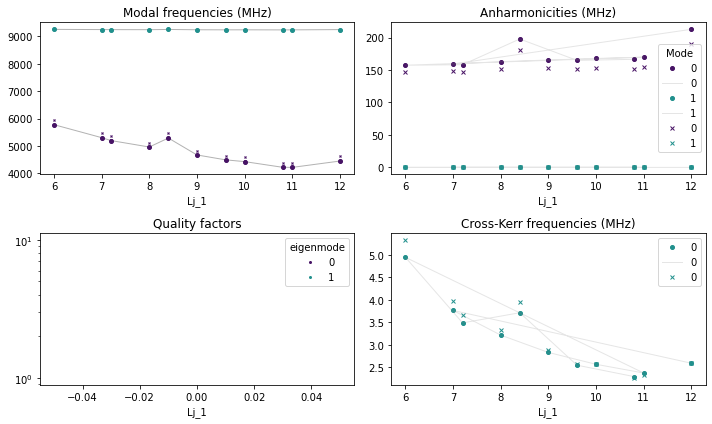

In [31]:
epra.results.sort_index = True
epra.plot_hamiltonian_results(swp_variable='Lj_1');

There is some jitter, since we have have run some of the runs to only a few passes here.

Please see Part II of the tutorial to continue. You will find it in the tutorial folder as a jupyter notebook. 

In [ ]:
epra.quick_plot_mode(0,0,1,numeric=True,swp_variable='Lj_1')

In [ ]:
epra.report_results(swp_variable='Lj_1', numeric=True)

# <div style="background:#BBFABB;line-height:2em;"> Addendum: <br> Snippets for ease <div>

An easy way to define many junctions is the following, using python3 f-strings for ease:

In [ ]:
# Specify multiple junctions in HFSS model
n_junctions = 5
for i in range(1, 1+n_junctions):
    pinfo.junctions[f'j{i}'] = {'Lj_variable' : f'Lj{i}',
                                'rect'        : f'JJrect{i}',
                                'line'        : f'JJline{i}',
                                'length'      : parse_units('100um')}

**NEXT:** Please see *Part II* of the tutorial to continue. You will find it in the tutorial folder as a jupyter notebook. 